In [8]:
# import dependencies for importing dependencies 
import torch
import transformers
from transformers import DonutProcessor

torch.__version__

'2.4.0'

In [14]:
tokenizer = transformers.AutoTokenizer.from_pretrained('donut-demo')
model = transformers.AutoModelForVision2Seq.from_pretrained("donut-demo")

In [27]:
from PIL import Image # type: ignore
import requests
import matplotlib.pyplot as plt

In [252]:
# FIXED: !pip install Pillow==9.5.0

processor = DonutProcessor.from_pretrained("donut-demo") # type: ignore

url = "https://help.kasirpintar.co.id/wp-content/uploads/2022/04/6.-tampilan-dari-cetak-struk.jpg"

image = Image.open(requests.get(url, stream=True).raw).convert("RGB") # type: ignore
image_from_local = Image.open('receipts/c-6.png').convert("RGB") # type: ignore
pixel_values = processor(image_from_local, return_tensors="pt").pixel_values

In [253]:
outputs = model.generate(pixel_values, max_length=512) # type: ignore

sequence = processor.decode(outputs[0], skip_special_tokens=True)
print(sequence) # type: ignore

<s_cord-v2><s_menu><s_nm> RAHMAT 1B (RDWGD GRMLFSH</s_nm><s_unitprice> 67.273</s_unitprice><s_cnt> 1</s_cnt><s_price> 67.273</s_price><s_sub><s_nm> GOKANA 3</s_nm><s_cnt> 1</s_cnt><s_price> 39.091</s_price><sep/><s_nm> ES TEH TAWAR</s_nm><s_cnt> 1</s_cnt><s_price> 9.091</s_price></s_menu><s_sub_total><s_subtotal_price> 115.455</s_subtotal_price><s_service_price> 12.700</s_service_price><s_tax_price> -2011</s_tax_price><s_etc> 115.5500</s_etc></s_sub_total><s_total><s_total_price> 139.500</s_total_price><s_creditcardprice> 139.500</s_creditcardprice><s_menuqty_cnt> 1</s_menuqty_cnt></s_total>


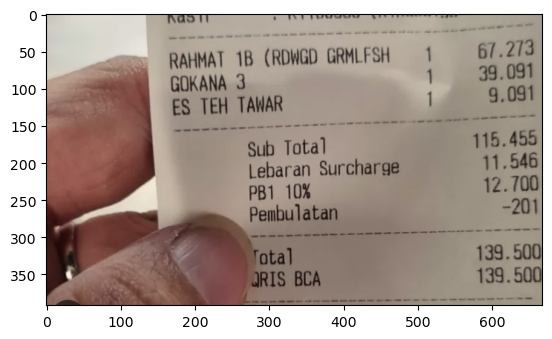

In [254]:
plt.imshow(image_from_local) # type: ignore

In [250]:
import re

def normalize_number(number_str):
    if ',' in number_str and '.' in number_str:
        if number_str.find(',') > number_str.find('.'):
            number_str = number_str.replace('.', '') 
            number_str = number_str.replace(',', '.') 
        else:
            number_str = number_str.replace(',', '')  

    elif ',' in number_str:
        number_str = number_str.replace(',', '')
    
    elif '.' in number_str:
        number_str = number_str.replace('.', '')

    return float(number_str) # type: ignore

In [255]:
import re
import json

def parse_receipt(text):
    # Regex patterns to extract data
    item_pattern = r"<s_nm>\s*(.*?)\s*</s_nm>(?:<s_unitprice>\s*([\d,\.]+)\s*</s_unitprice>)?<s_cnt>\s*(\d+)\s*(?:X)?\s*</s_cnt><s_price>\s*(?:Rp\s*)?([\d,\.]+)\s*</s_price>"
    total_pattern = r"<s_subtotal_price>\s*:?[\s]*([\d,\.]+)\s*</s_subtotal_price>"
    a_total_pattern = r"<s_total_price>\s*:?[\s]*([\d,\.]+)\s*</s_total_price>"

    # Extract items
    items = re.findall(item_pattern, text)

    # Extract subtotal
    total_match = re.search(a_total_pattern, text)
    subtotal_match = re.search(total_pattern, text)
    total = normalize_number(total_match.group(1))
    subtotal = normalize_number(subtotal_match.group(1))

    # Create a structured dictionary
    receipt = {
        "items": [
            {
                "name": name.strip(),
                "unit_price": float(unit_price.replace('.', '').replace(',', '.')) if unit_price else None, # type: ignore
                "count": int(count), # type: ignore
                "price": float(normalize_number(price)) # type: ignore
            }
            for name, unit_price, count, price in items
        ],
        "subtotal": subtotal,
        "total": total
    }

    return json.dumps(receipt, indent=4)

receipt_json1 = parse_receipt(sequence)

print(receipt_json1) # type: ignore


{
    "items": [
        {
            "name": "RAHMAT 1B (RDWGD GRMLFSH",
            "unit_price": 67273.0,
            "count": 1,
            "price": 67273.0
        },
        {
            "name": "GOKANA 3",
            "unit_price": null,
            "count": 1,
            "price": 39091.0
        },
        {
            "name": "ES TEH TAWAR",
            "unit_price": null,
            "count": 1,
            "price": 9091.0
        }
    ],
    "subtotal": 115455.0,
    "total": 139500.0
}


## cleaner 1

In [256]:
import json
import re

def clean_json_data(receipt_json):
    # Load the JSON string into a Python dictionary
    receipt = json.loads(receipt_json)
    
    # Define a regex pattern that likely matches item names (excluding dates/times)
    # This pattern assumes item names are typically words (with potential spaces)
    valid_name_pattern = r"^[A-Za-z\s]+$"
    
    # Filter out items where the name doesn't match the expected pattern
    filtered_items = [
        item for item in receipt["items"]
        if re.match(valid_name_pattern, item["name"].strip())
    ]
    
    # Update the receipt dictionary with the filtered items
    receipt["items"] = filtered_items
    
    # Convert the updated dictionary back to a JSON string
    return json.dumps(receipt, indent=4)

cleaned_json = clean_json_data(receipt_json1)
print(cleaned_json) # type: ignore


{
    "items": [
        {
            "name": "ES TEH TAWAR",
            "unit_price": null,
            "count": 1,
            "price": 9091.0
        }
    ],
    "subtotal": 115455.0,
    "total": 139500.0
}


## cleaner 2

In [196]:
import json
import re

def clean_json_data(receipt_json):
    # Load the JSON string into a Python dictionary
    receipt = json.loads(receipt_json)
    
    # Define a more flexible pattern for valid item names
    valid_name_pattern = r"^[A-Za-z\s\-]+(?: [A-Za-z\s\-]+)*$"

    bad_patterns = [
        r"\d{2} \w{3} \d{2}",  # Date pattern like "10 May 19"
        r"\(\d{3,}\)",         # Phone number pattern like "(021)"
        r"Check No :",         # Patterns indicating non-item entries
        r"WWW\.",              # URLs
    ]
    
    def is_invalid_name(name):
        # Strip any potential HTML tags
        name = re.sub(r"<.*?>", "", name).strip()
        
        # Check against bad patterns
        for pattern in bad_patterns:
            if re.search(pattern, name):
                return True
        return not re.match(valid_name_pattern, name)
    
    # Filter and clean items
    filtered_items = []
    for item in receipt["items"]:
        if not is_invalid_name(item["name"]):
            # Clean the name by removing unnecessary tags or patterns
            item["name"] = re.sub(r"<.*?>", "", item["name"]).strip()
            filtered_items.append(item)
    
    receipt["items"] = filtered_items
    return json.dumps(receipt, indent=4)

cleaned_json = clean_json_data(receipt_json1)
print(cleaned_json)


{
    "items": [
        {
            "name": "Teh WANTC hargat",
            "unit_price": null,
            "count": 3,
            "price": 30000.0
        }
    ],
    "subtotal": 0.0,
    "total": 0.0
}


## cleaner 3 (feat Language Model)

In [197]:
from transformers import pipeline

# Function to clean data using a Hugging Face model
def clean_json_data_with_hf(receipt_json):
    classifier = pipeline("ner", model="dbmdz/bert-large-cased-finetuned-conll03-english")
    receipt = json.loads(receipt_json)

    cleaned_items = []
    for item in receipt["items"]:
        ner_results = classifier(item["name"])
        cleaned_name = " ".join([res['word'] for res in ner_results if res['entity'] == 'B-MISC' or res['entity'] == 'I-MISC'])

        if cleaned_name:
            item["name"] = cleaned_name
            cleaned_items.append(item)
    
    receipt["items"] = cleaned_items
    
    return json.dumps(receipt, indent=4)

cleaned_json = clean_json_data_with_hf(receipt_json1)
print(cleaned_json) # type: ignore


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


{
    "items": [],
    "subtotal": 0.0,
    "total": 0.0
}


In [187]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def crop_receipt(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edged = cv2.Canny(blurred, 50, 150)
    contours, _ = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    receipt_contour = contours[0]

    x, y, w, h = cv2.boundingRect(receipt_contour)
    cropped_image = image[y:y+h, x:x+w]

    # Save the cropped image
    cropped_image_path = image_path.replace('.png', '_cropped.png')
    cv2.imwrite(cropped_image_path, cropped_image)

    # Display the cropped image
    plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    return cropped_image_path

image_path = "/receipts/c-6.png"
cropped_image_path = crop_receipt(image_path)
print(f"Cropped image saved at: {cropped_image_path}")


ModuleNotFoundError: No module named 'cv2'